## ValidMind Model diagnosis test Plan

- Dataset: bank customer churn dataset: https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data
- Two models: we want to allow the model diagnosis functions to work for statsmodels and sklearn model interfaces since they have different predict() signatures.
  - XGBoost/SKLearn classifier
  - Logistic Regression with statsmodels
- Test plans
  - Model weak spots
    - Single variable only
  - Model overfit
    - Single variable only
  - Model robustness
    - All features and single feature
- Reference: 
  - PiML Toolbox: https://github.com/SelfExplainML/PiML-Toolbox
  - Example notebook with model diagnosis: https://colab.research.google.com/github/SelfExplainML/PiML-Toolbox/blob/main/examples/Example_BikeSharing.ipynb

### Initializing the ValidMind Library

After creating an account with ValidMind, we can find the project's API key and secret in the settings page of the ValidMind dashboard:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/settings.png" width="600" height="300" />

The library credentials can be configured in two ways:

- By setting the `VM_API_KEY` and `VM_API_SECRET` environment variables or
- By passing `api_key` and `api_secret` arguments to the `init` function like this:

```python
vm.init(
    api_key='<your-api-key>',
    api_secret='<your-api-secret>',
    project="cl2r3k1ri000009jweny7ba1g"
)
```

The `project` argument is mandatory since it allows the library to associate all data collected with a specific account project.

In [1]:
# Quick hack to load local SDK code
import os

os.chdir(os.path.join(os.getcwd(), ".."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgmfxwvp0000k8rlc997oe9t"
)

True

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb

from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

### Running a data quality test plan

We will now run the default data quality test plan that will collect the
following metadata from a dataset:

- Field types and descriptions
- Descriptive statistics
- Data distribution histograms
- Feature correlations

and will run a collection of data quality tests such as:

- Class imbalance
- Duplicates
- High cardinality
- Missing values
- Skewness

ValidMind evaluates if the data quality metrics are within expected ranges. These thresholds or ranges can be further configured by model validators.

### Load our demo dataset

Before running the test plan, we must first load the dataset into a Pandas DataFrame and initialize
a ValidMind dataset object:

In [3]:
df = pd.read_csv("./notebooks/datasets/bank_customer_churn.csv")

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="Exited",
    class_labels={
        "0": "Did not exit",
        "1": "Exited",
    }
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


### Preparing the dataset for training

Before we train a model, we need to run some common minimal feature selection and engineering steps on the dataset:

- Dropping irrelevant variables
- Encoding categorical variables

#### Dropping irrelevant variables

The following variables will be dropped from the dataset:

- `RowNumber`: it's a unique identifier to the record
- `CustomerId`: it's a unique identifier to the customer
- `Surname`: no predictive power for this variable
- `CreditScore`: we didn't observer any correlation between `CreditScore` and our target column `Exited`

In [4]:
df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)

#### Encoding categorical variables

We will apply one-hot or dummy encoding to the following variables:

- `Geography`: only 3 unique values found in the dataset
- `Gender`: convert from string to integer

In [5]:
genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)

In [6]:
df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

We are now ready to train our model with the preprocessed dataset:

In [7]:
df.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


#### Dataset preparation

For training our model, we will **randomly** split the dataset in 3 parts:

- `training` split with 60% of the rows
- `validation` split with 20% of the rows
- `test` split with 20% of the rows

The `test` dataset will be our held out dataset for model evaluation.

In [8]:
train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_df.drop("Exited", axis=1)
y_train = train_df.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

### Model training

We will train a simple XGBoost model and set its `eval_set` to `[(x_train, y_train), (x_val, y_val)]` in order to collect validation datasets metrics on every round. The ValidMind library supports collecting any type of "in training" metrics so model developers can provide additional context to model validators if necessary.

In [9]:
model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [10]:
y_pred = model.predict_proba(x_val)[:, -1]
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.95875


#### Initialize VM model object and train/test datasets

In order to run our SKLearnClassifier test plan, we need to initialize ValidMind object instances for the trained model and the training and test datasets:

In [11]:
vm_model = vm.init_model(model)
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column="Exited")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic", target_column="Exited")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


### Finding all test plans available in the developer framework

We can find all the test plans available in the developer framework by calling the following functions:

- All test plans: `vm.test_plans.list_plans()`
- Describe a test plan: `vm.test_plans.describe_plan("sklearn_classifier")`
- List available diagnosis tests: `vm.test_plans.describe_plan("sklearn_classifier_model_diagnosis")`

As an example, here's the outpout `list_plans()` and `list_tests()`:

In [12]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier_model_diagnosis,SKLearnClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.


In [13]:
vm.test_plans.describe_plan("sklearn_classifier")

Attribute,Value
ID,sklearn_classifier
Name,SKLearnClassifier
Description,Test plan for sklearn classifier models that includes both metrics and validation tests
Required Context,"['model', 'train_ds', 'test_ds']"
Tests,
Test Plans,"['sklearn_classifier_metrics', 'sklearn_classifier_validation', 'sklearn_classifier_model_diagnosis']"


In [14]:
vm.test_plans.describe_plan("sklearn_classifier_model_diagnosis")

Attribute,Value
ID,sklearn_classifier_model_diagnosis
Name,SKLearnClassifierDiagnosis
Description,Test plan for sklearn classifier model diagnosis tests
Required Context,"['model', 'train_ds', 'test_ds']"
Tests,"OverfitDiagnosisTest (ThresholdTest), WeakspotsDiagnosisTest (ThresholdTest), RobustnessDiagnosisTest (ThresholdTest)"
Test Plans,[]


### Run model diagnosis test plan
We can now run the `SKLearnClassifier->SKLearnClassifierDiagnosis` test plan:
#### Define config

Running ThresholdTest: overfit_regions:   0%|          | 0/3 [00:00<?, ?it/s]                 Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scal


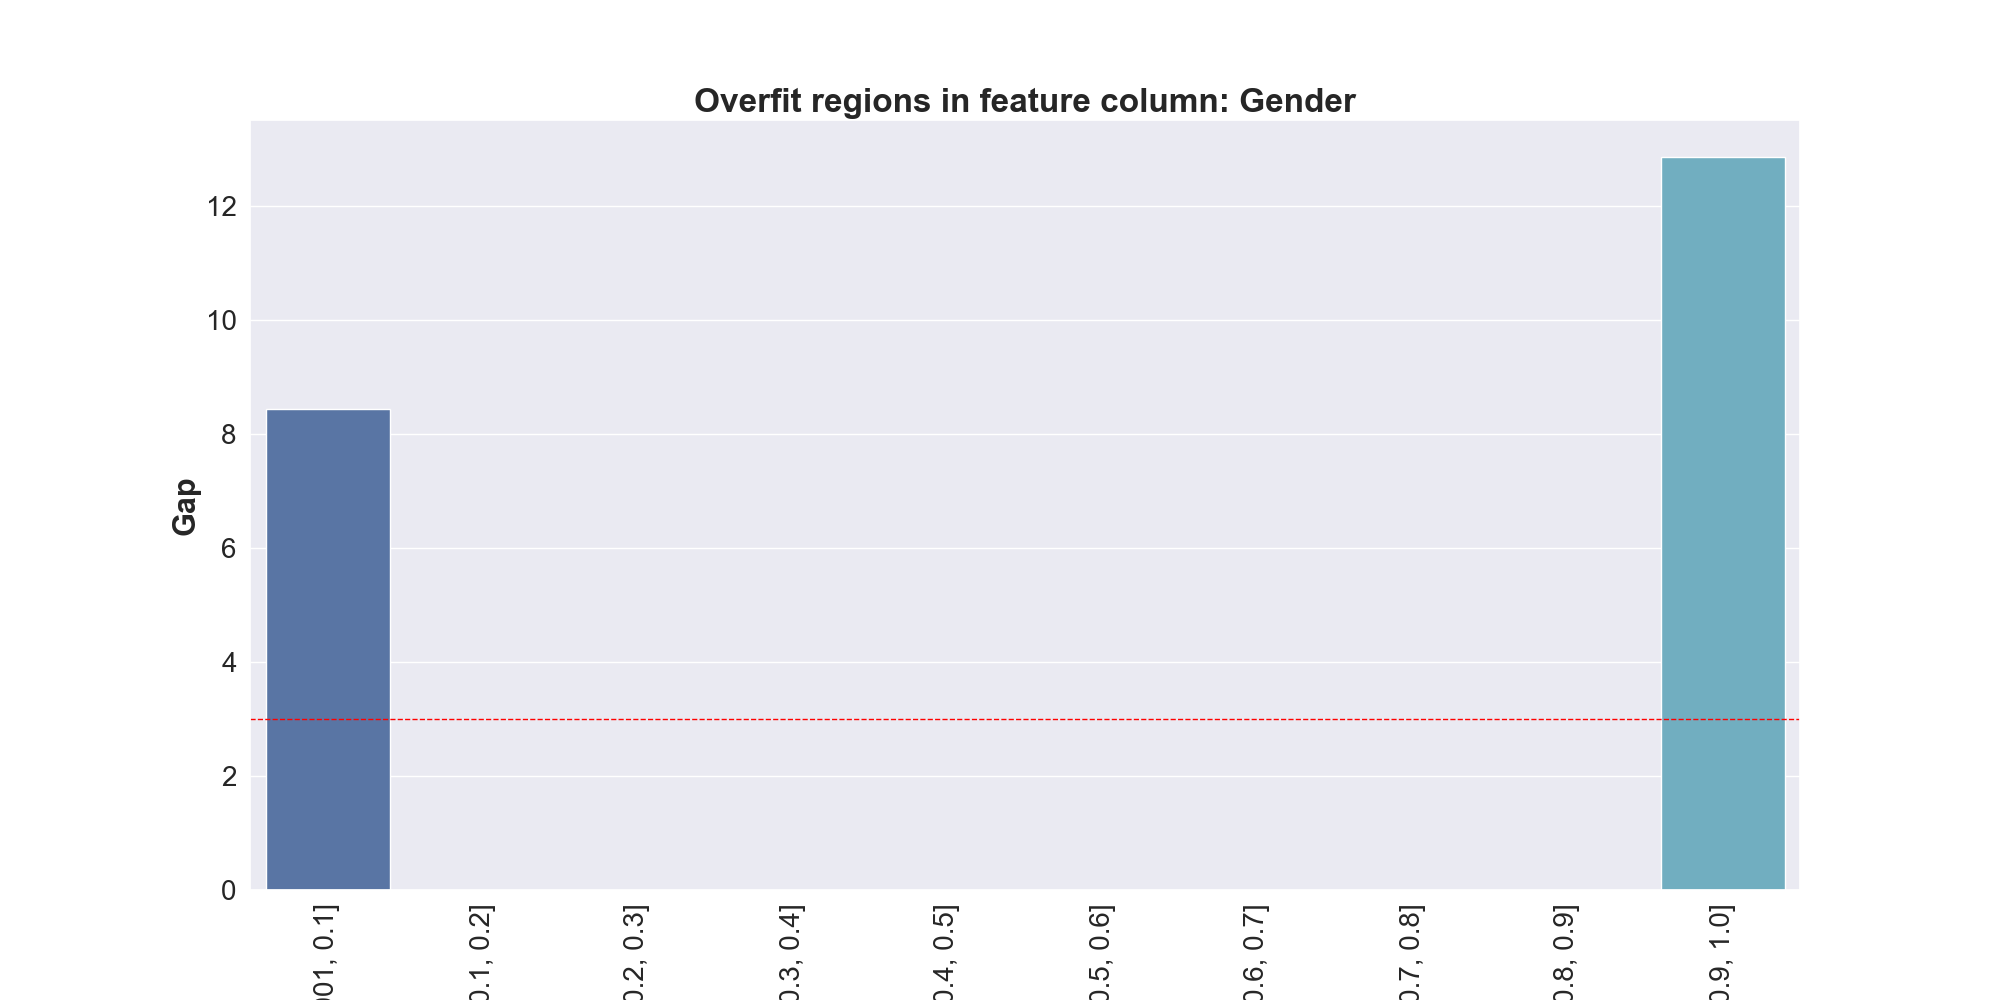
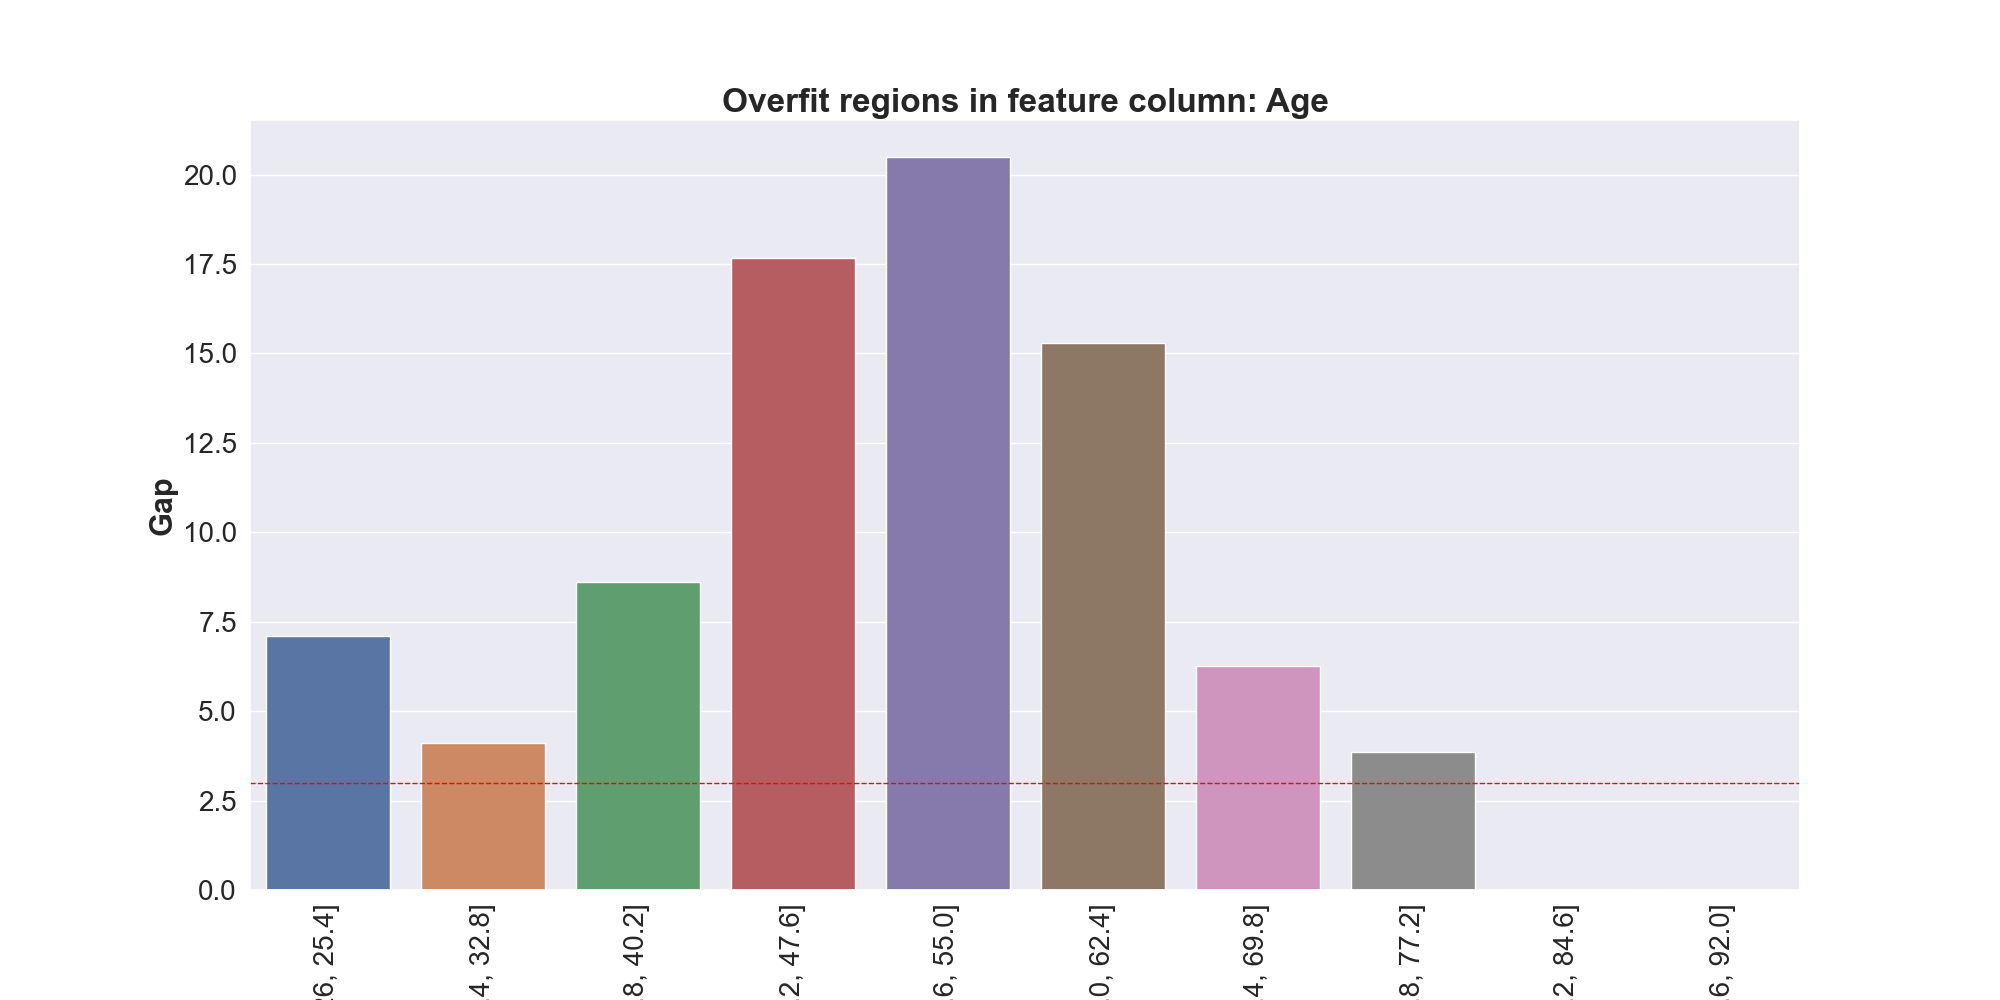
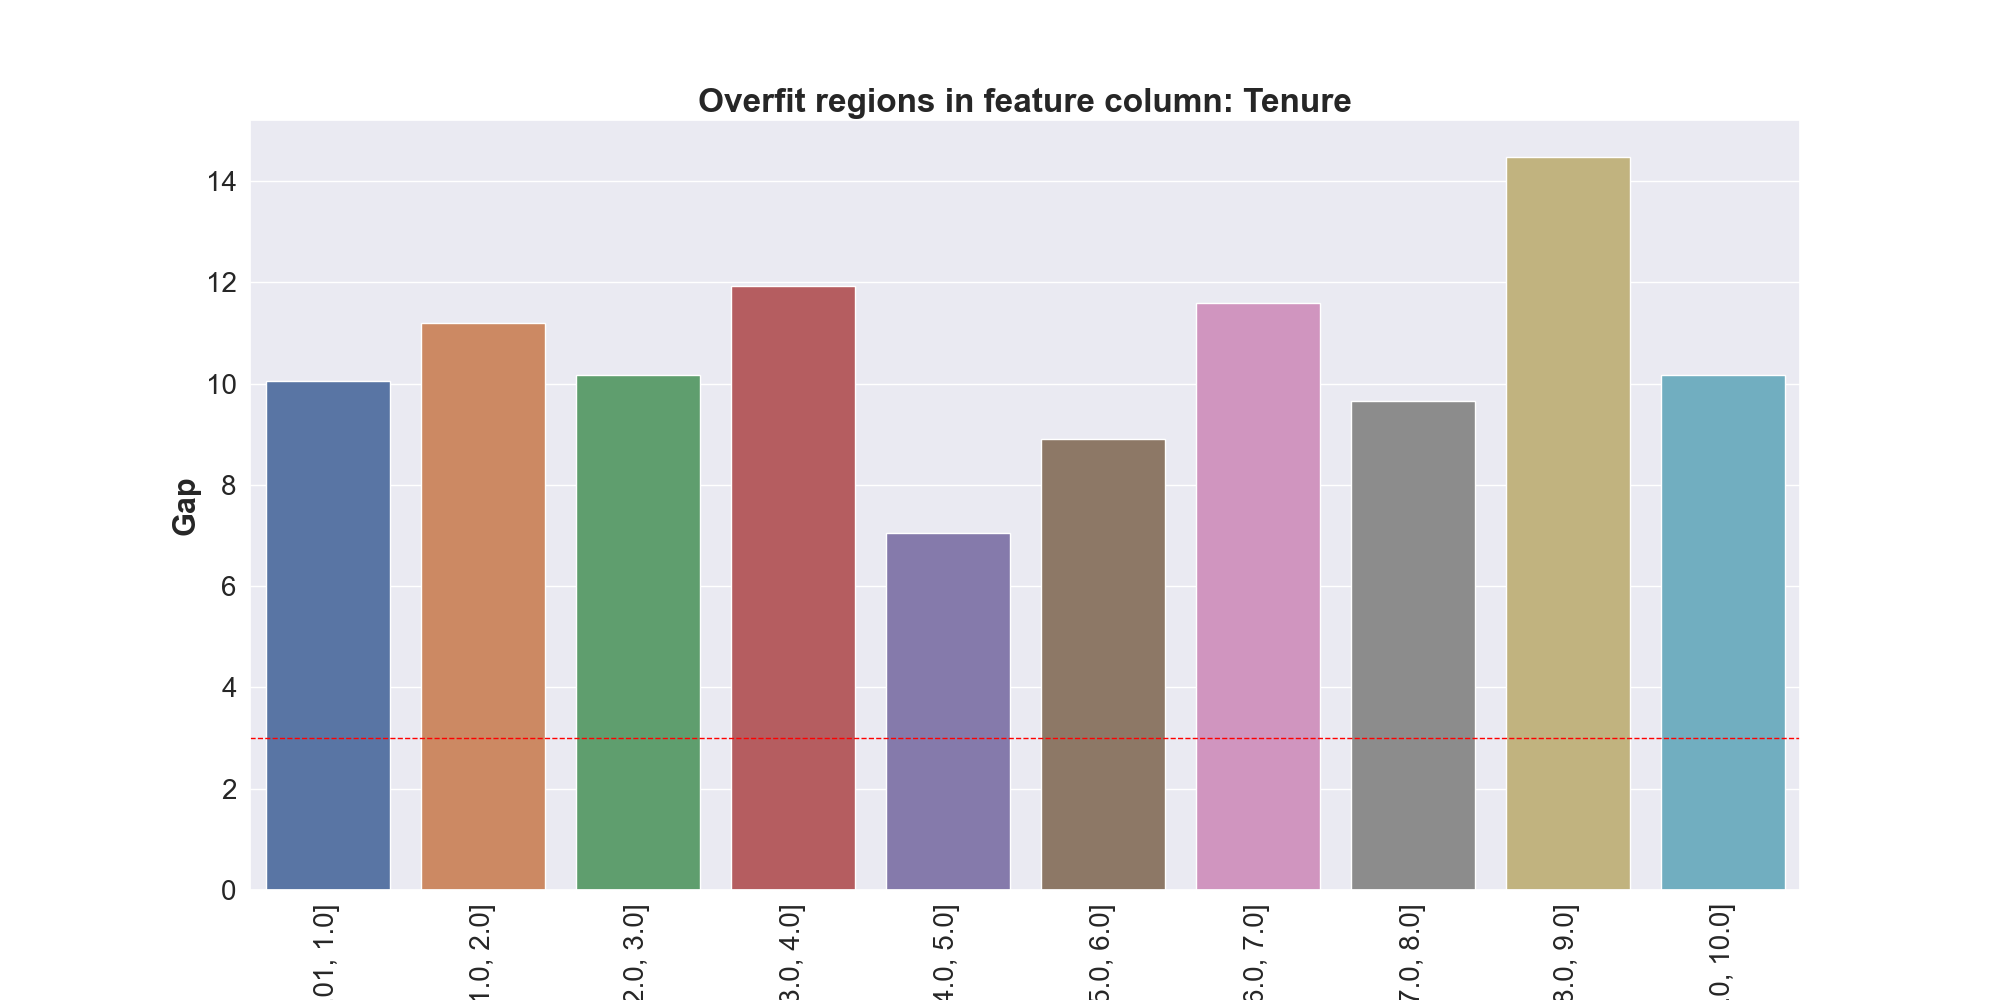
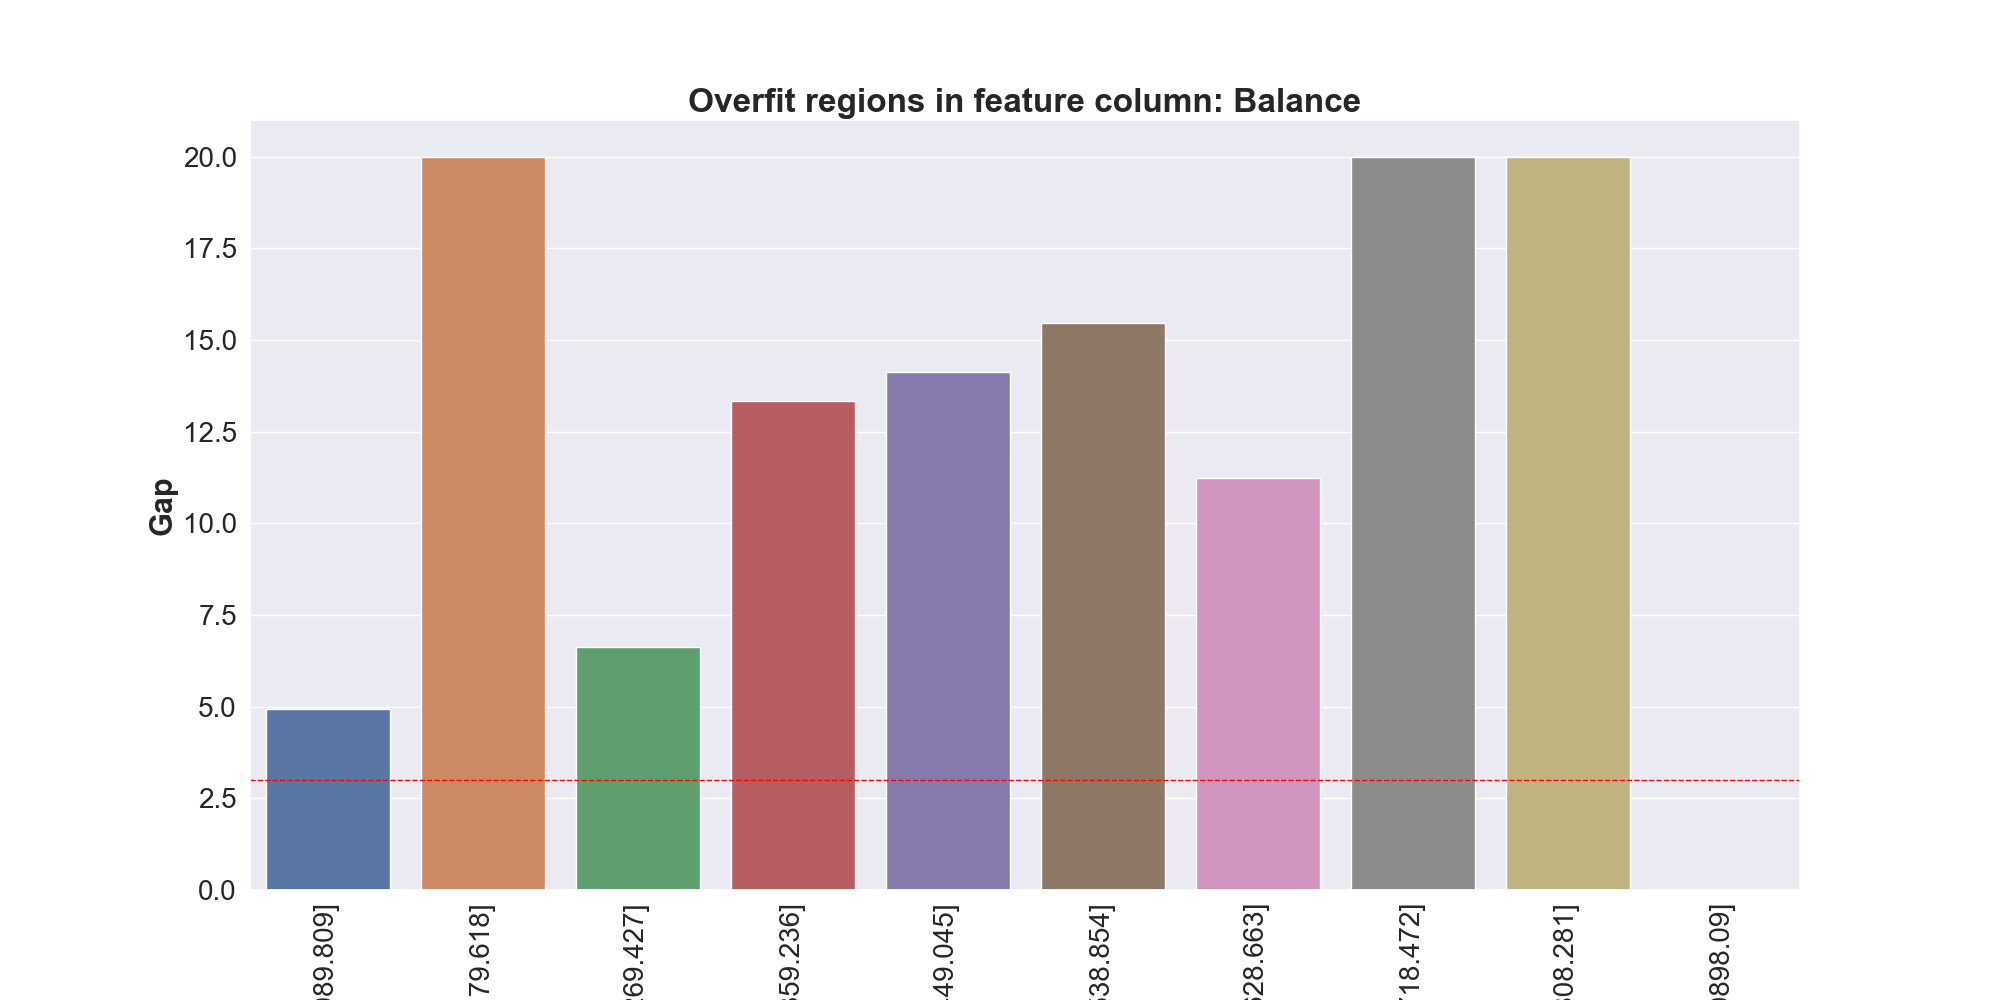
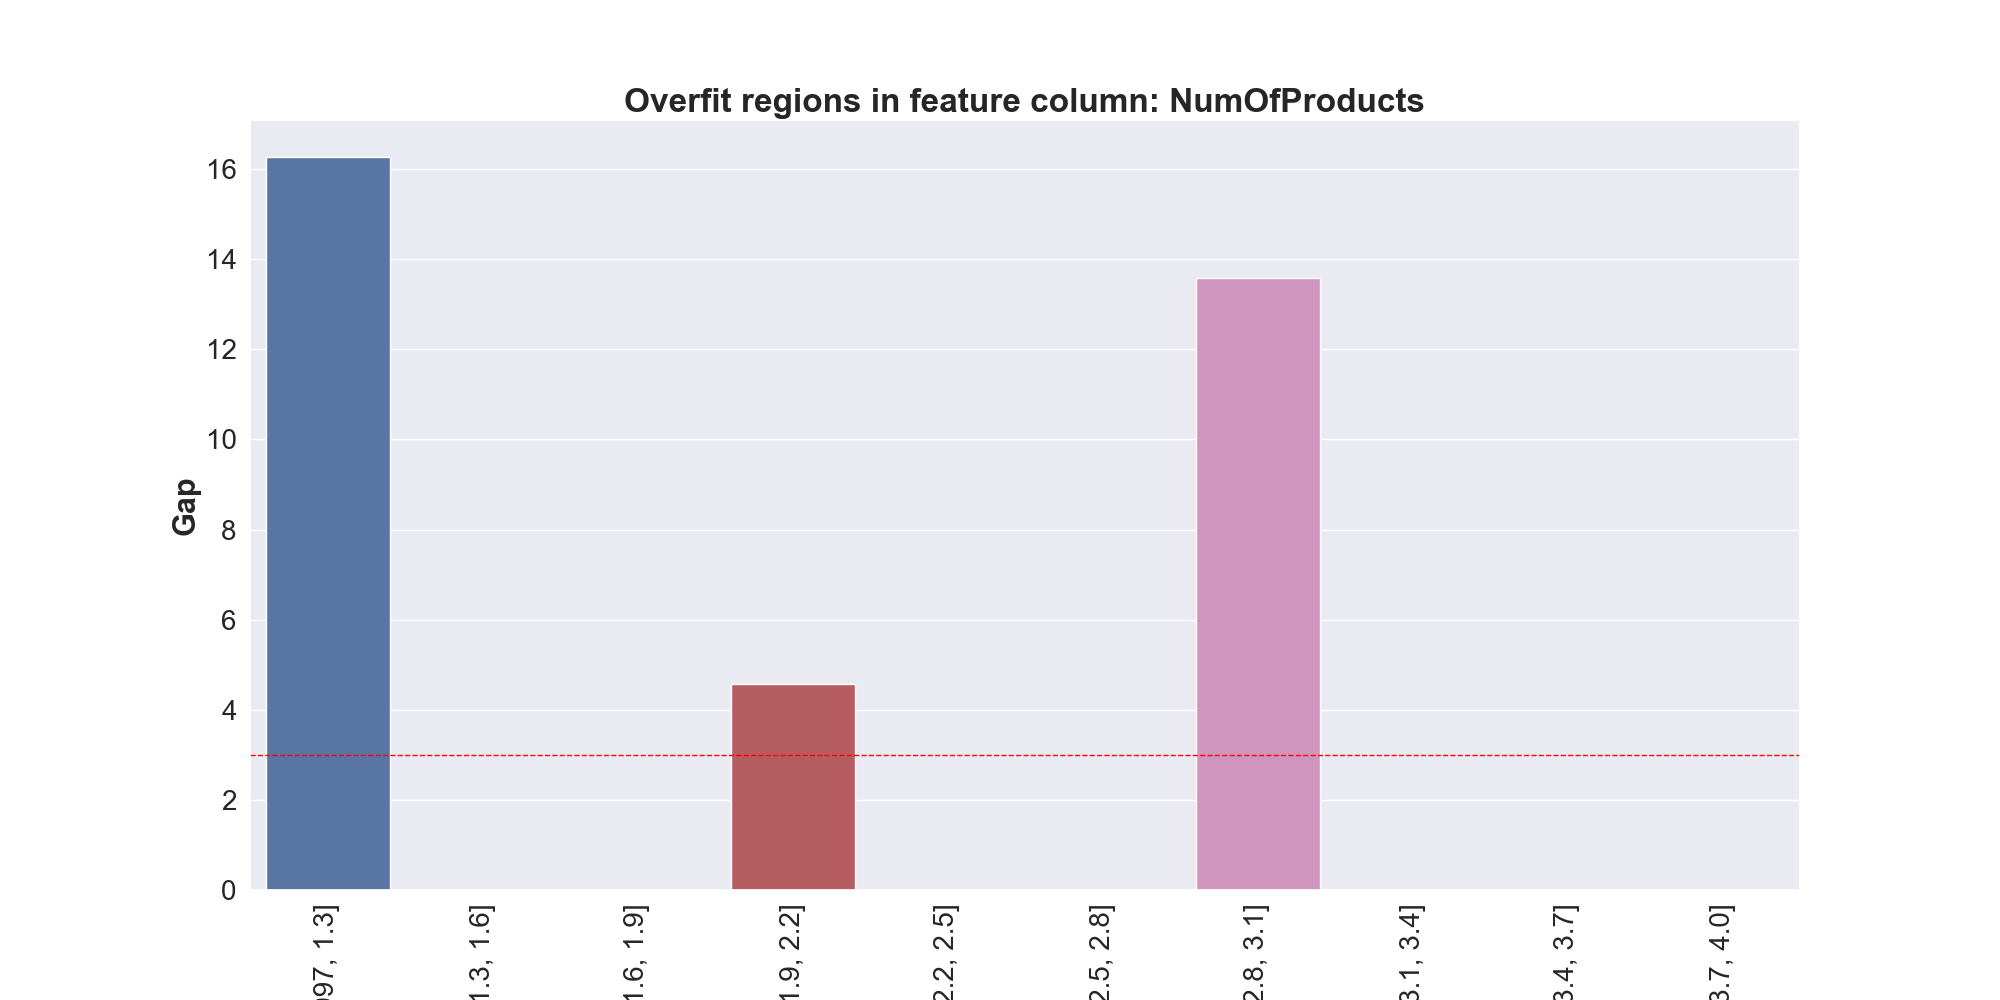
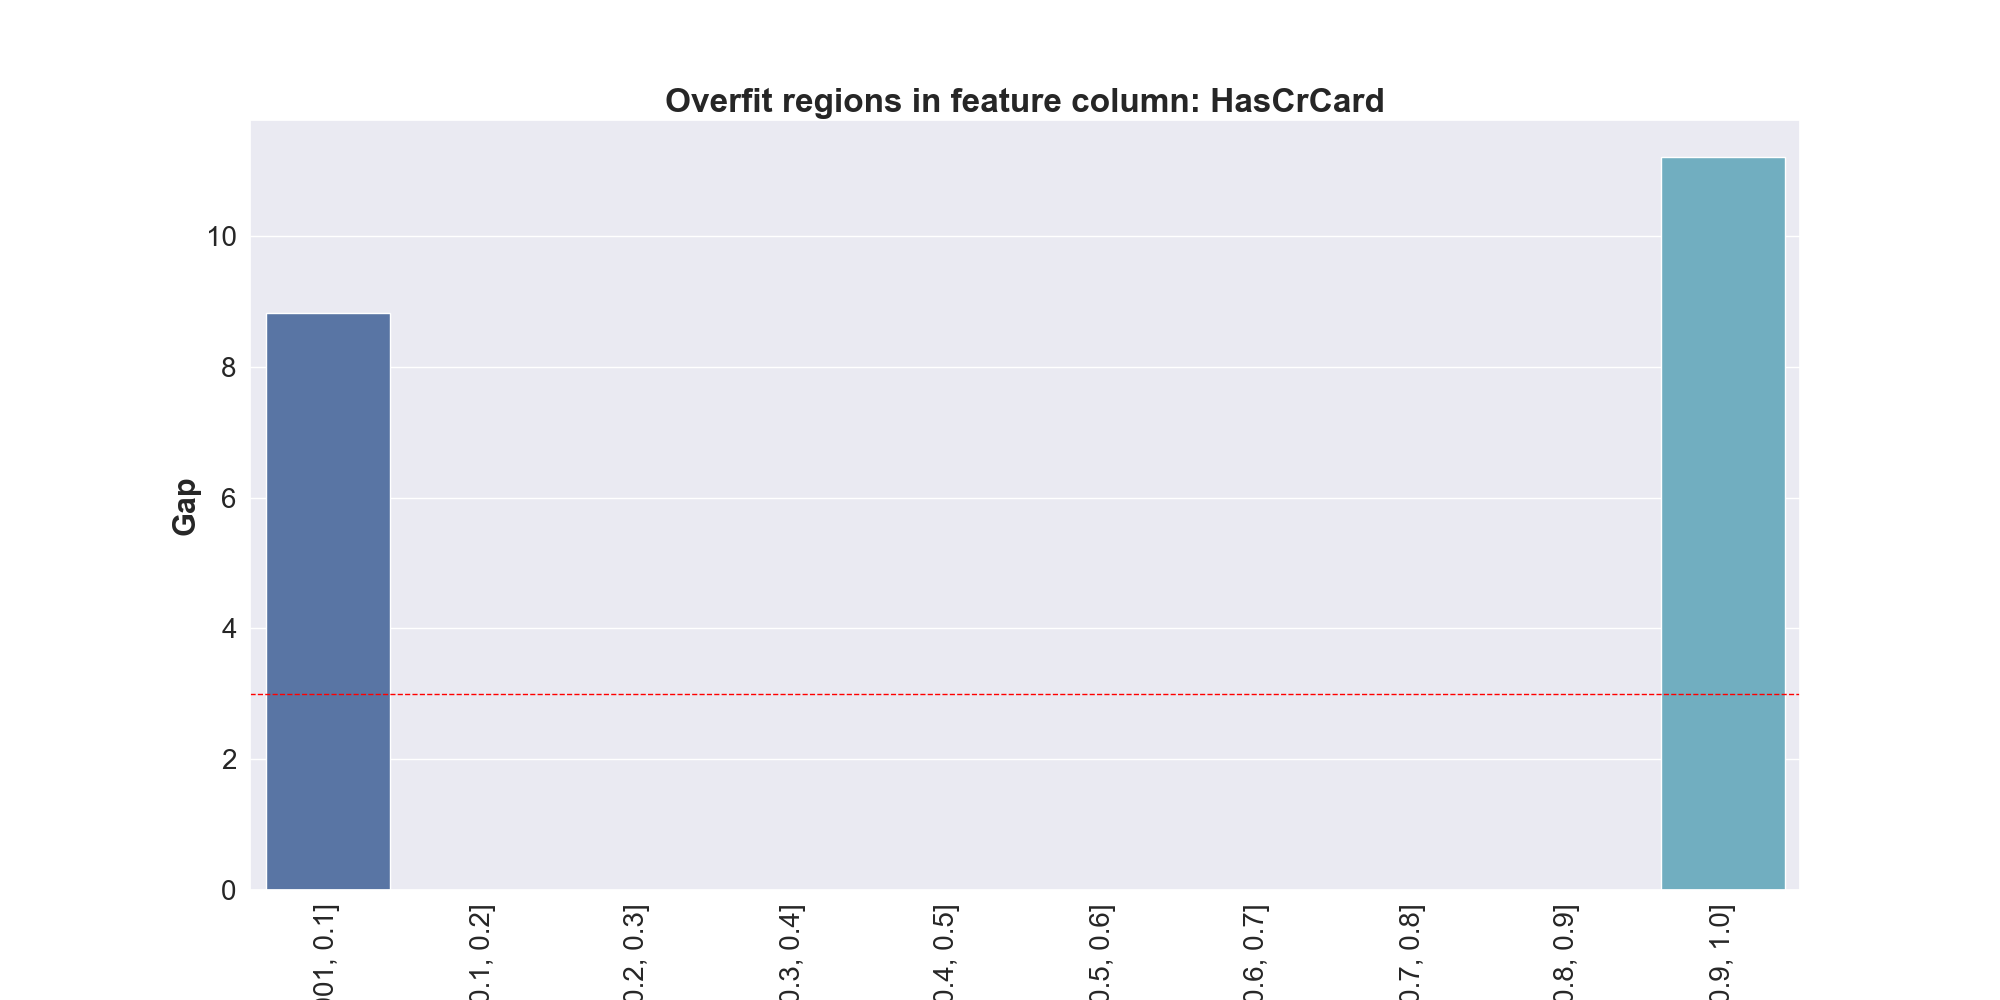
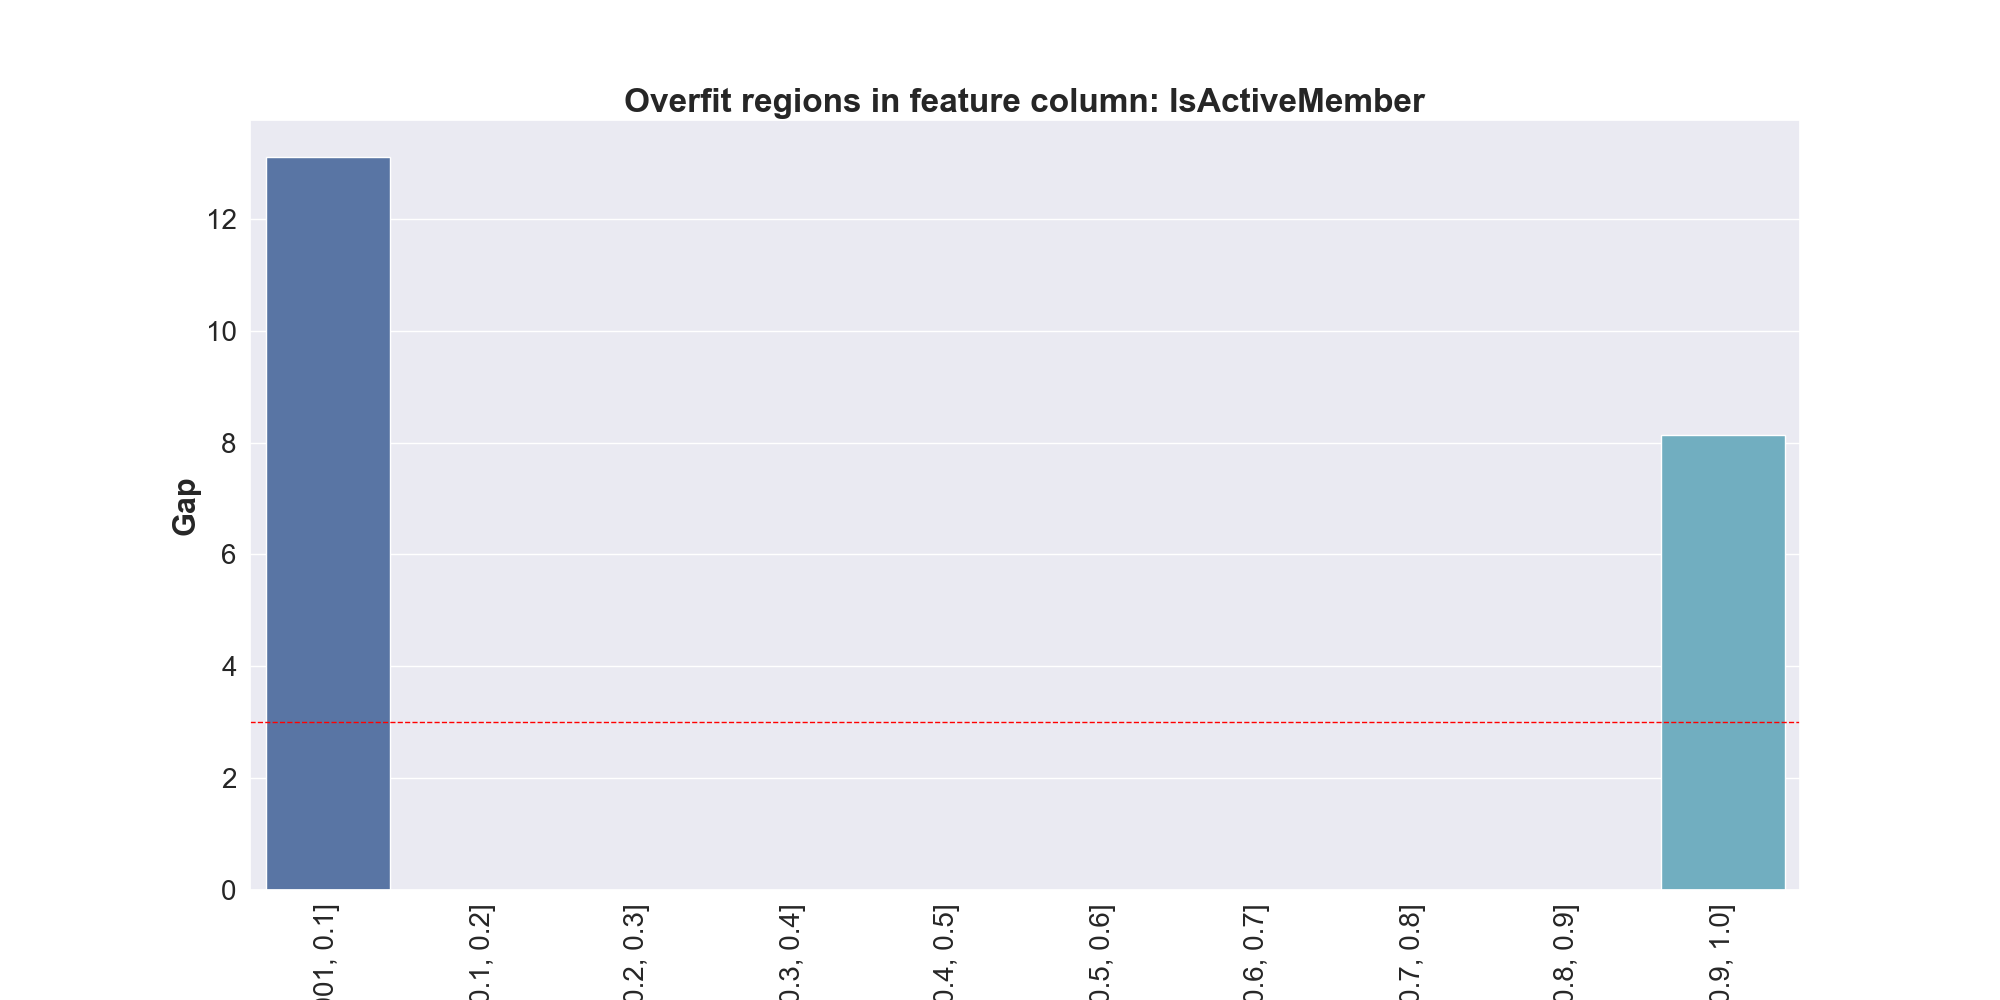
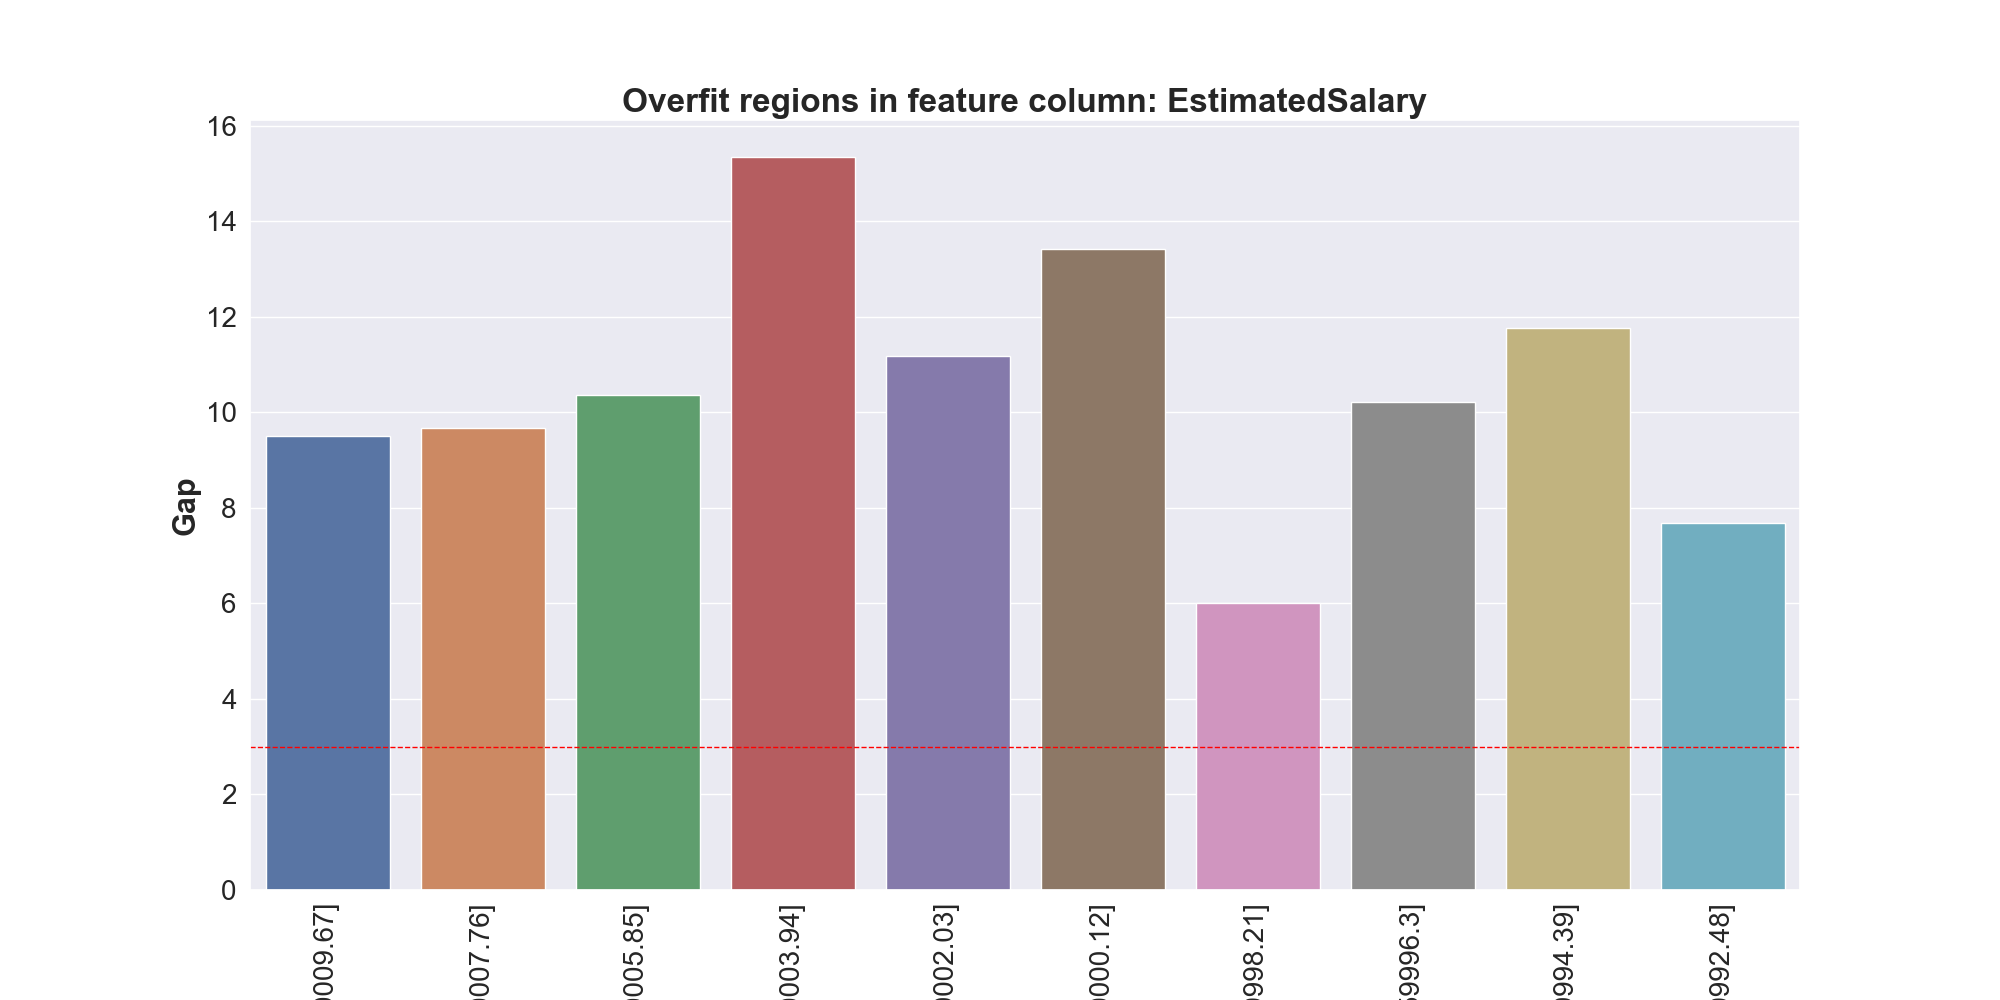
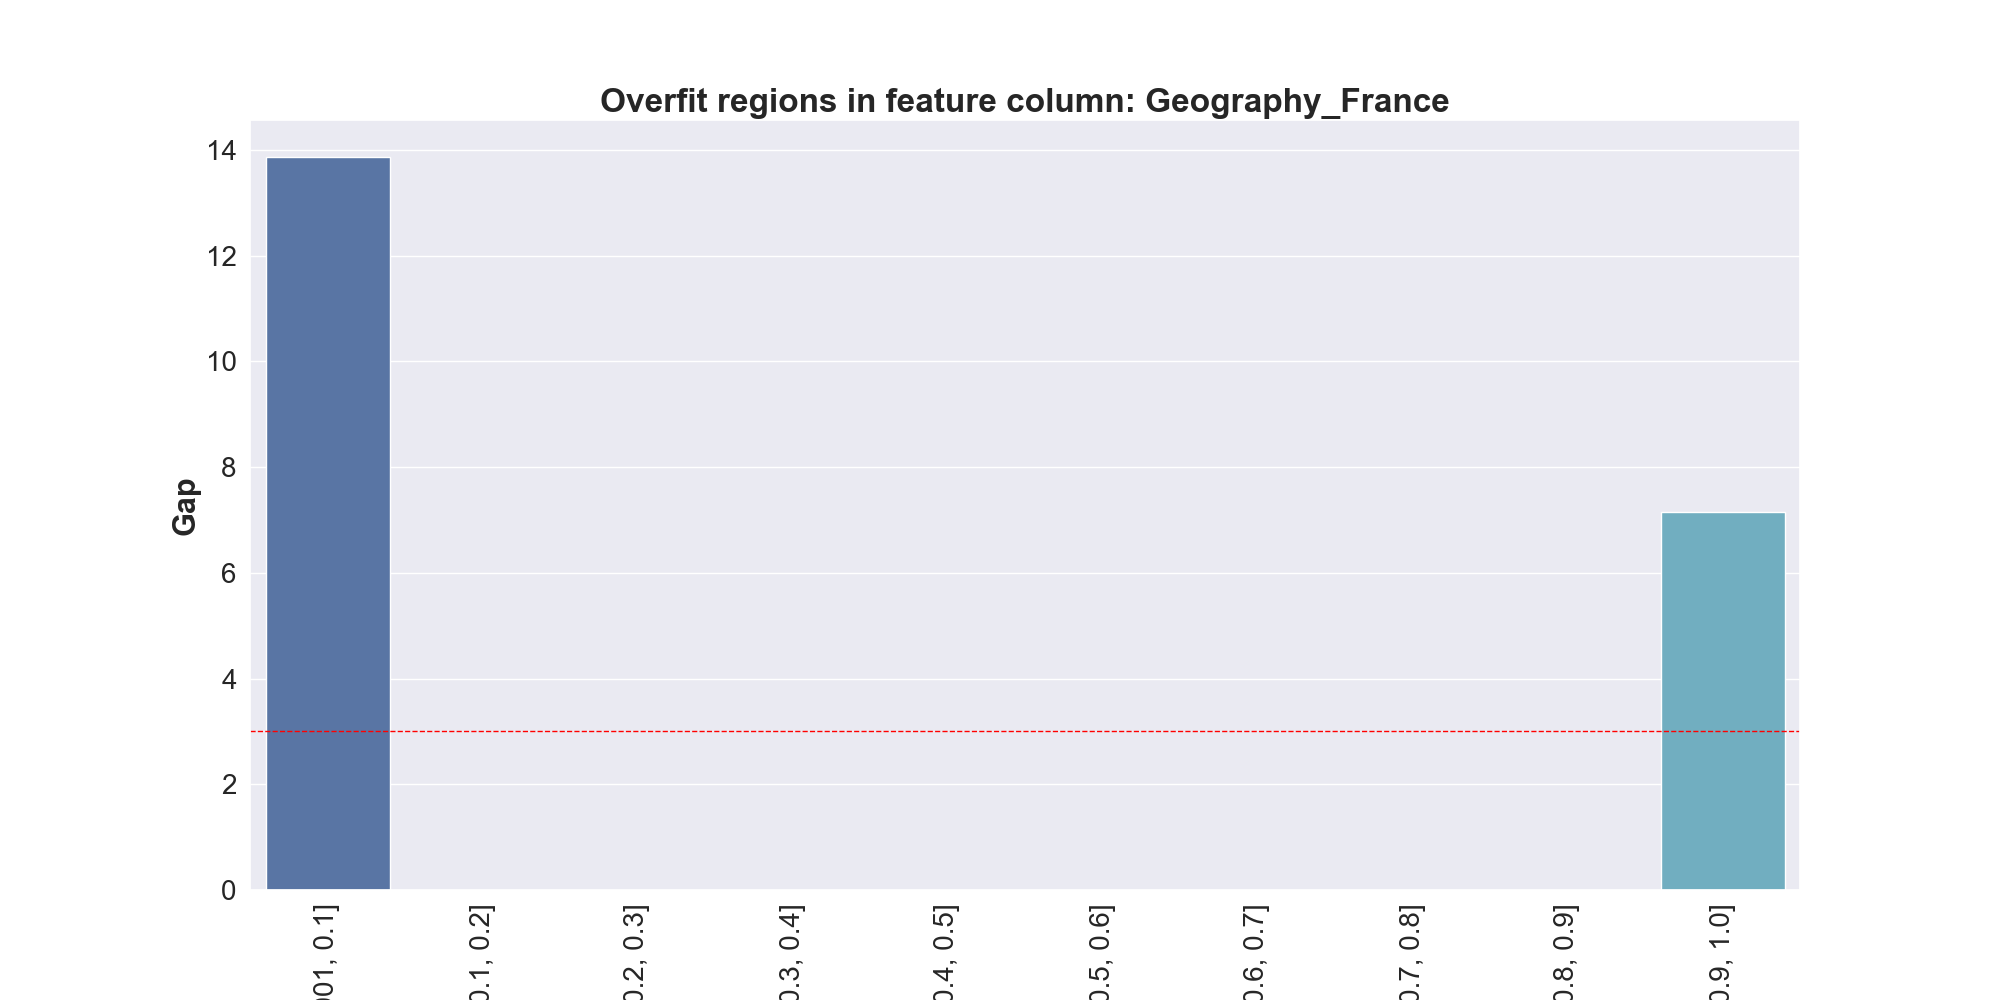
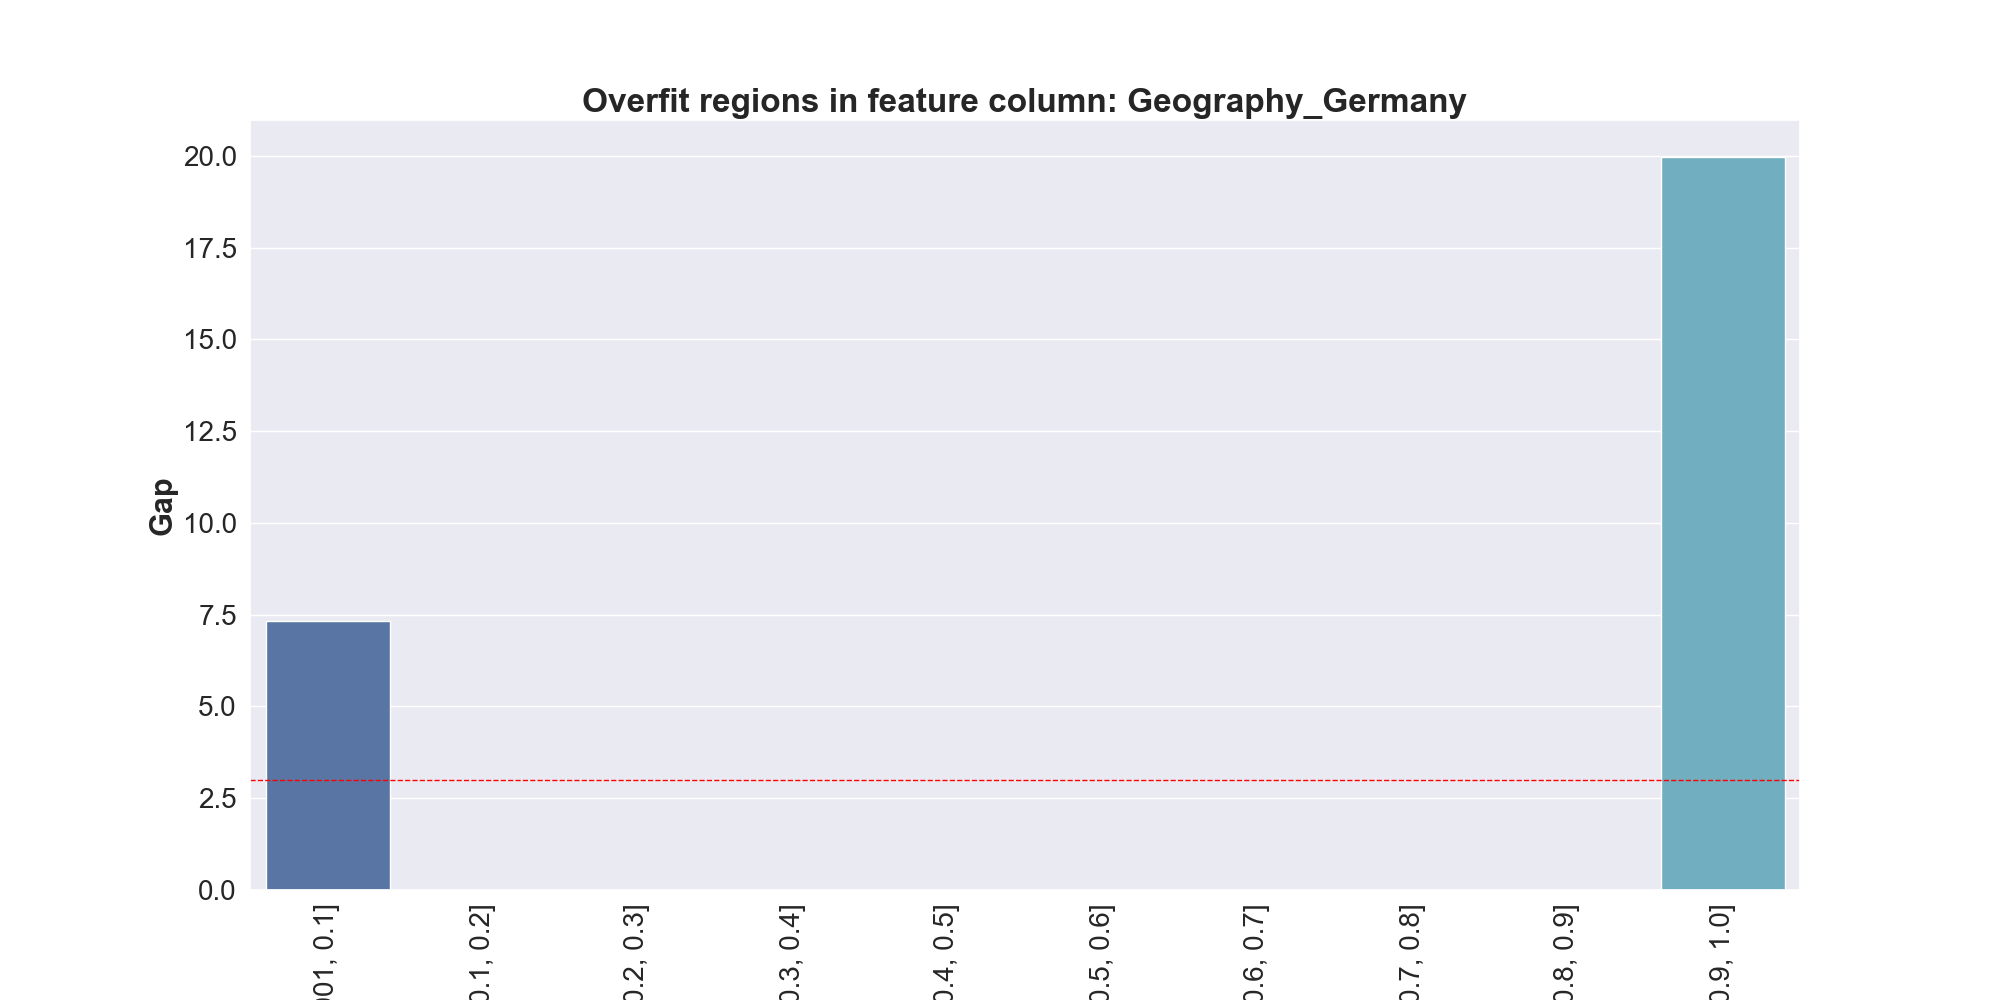
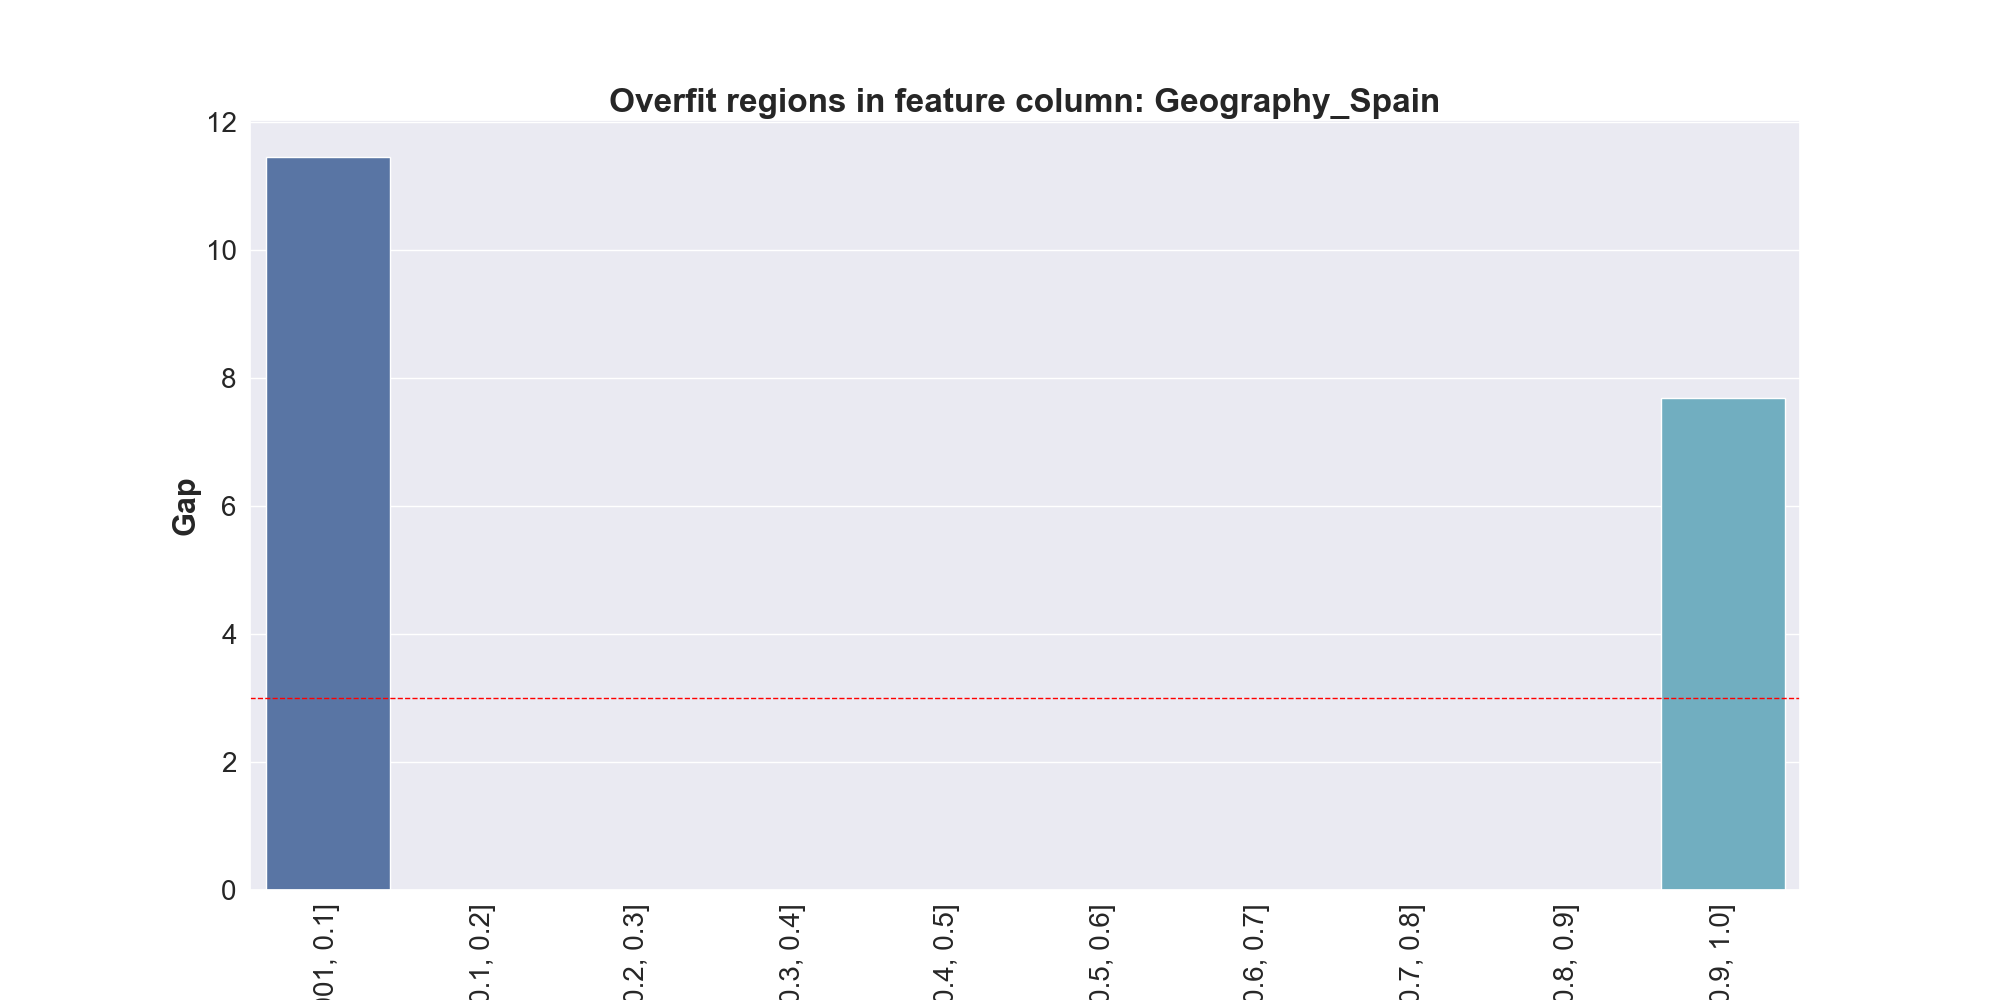
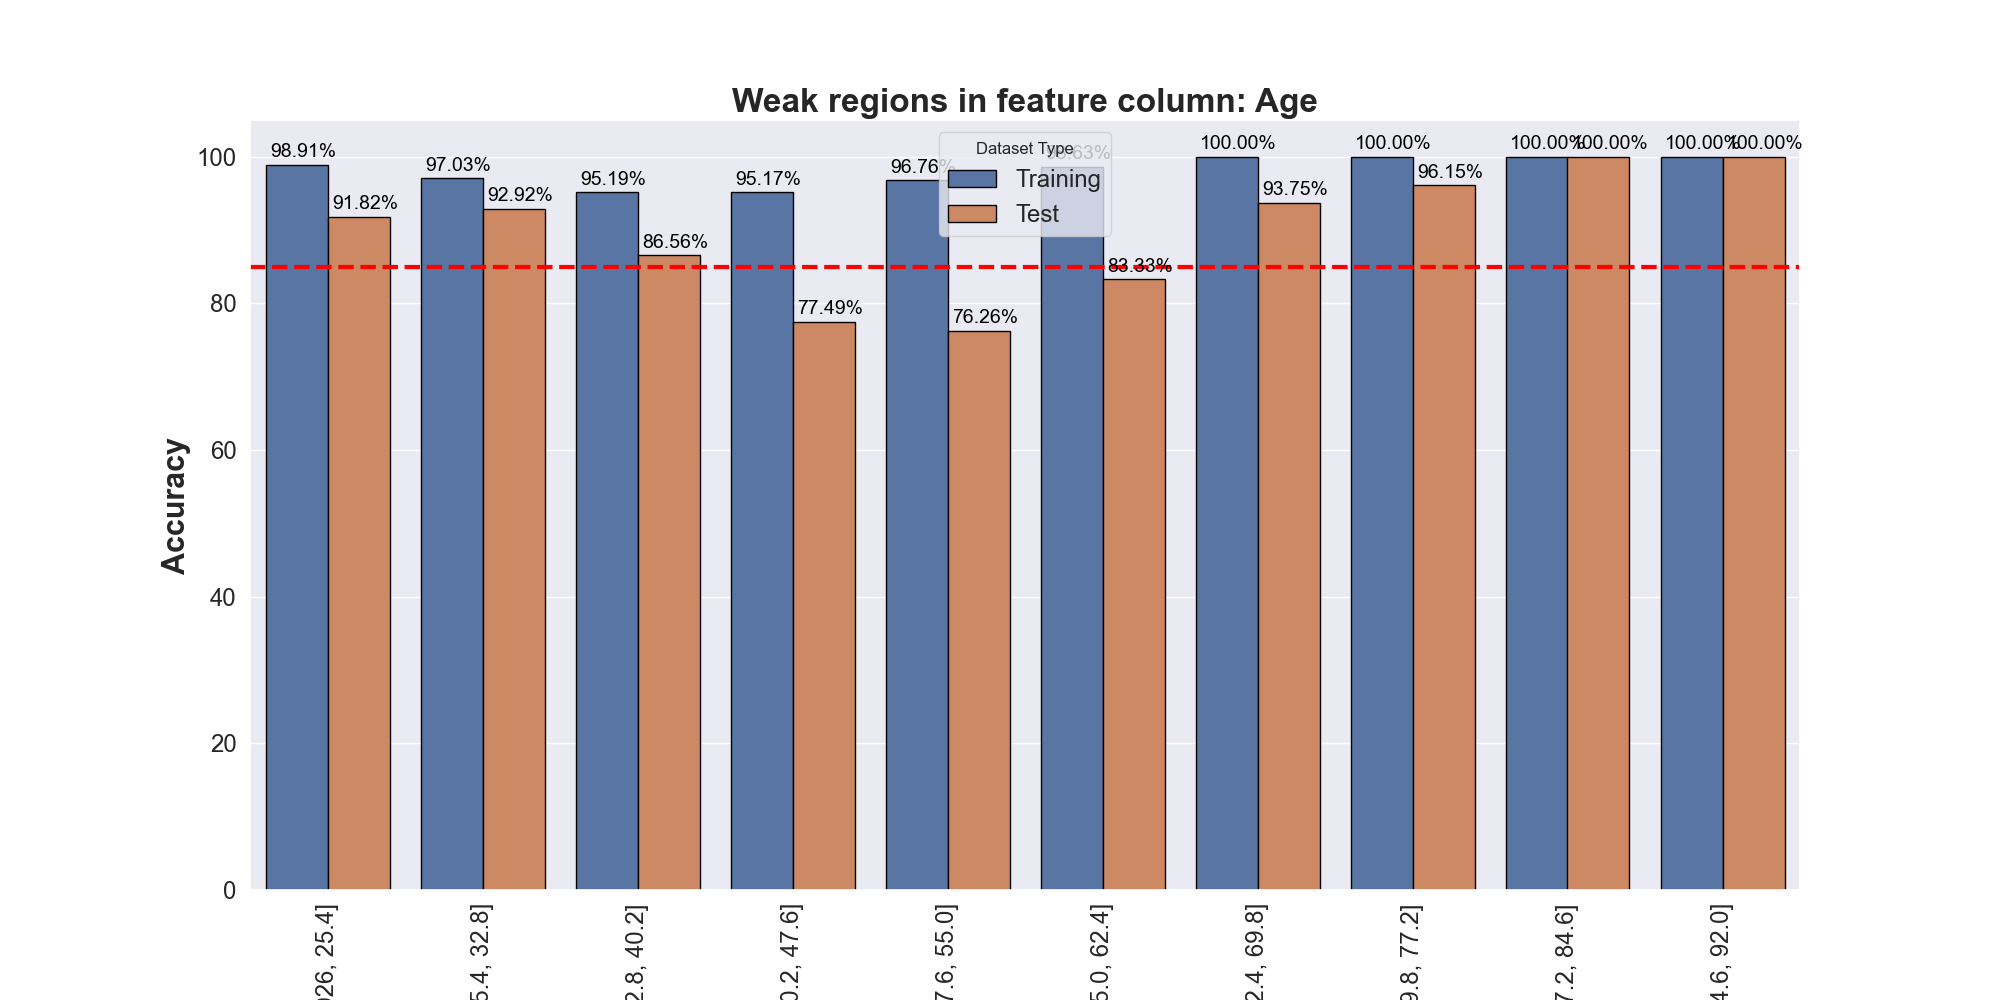
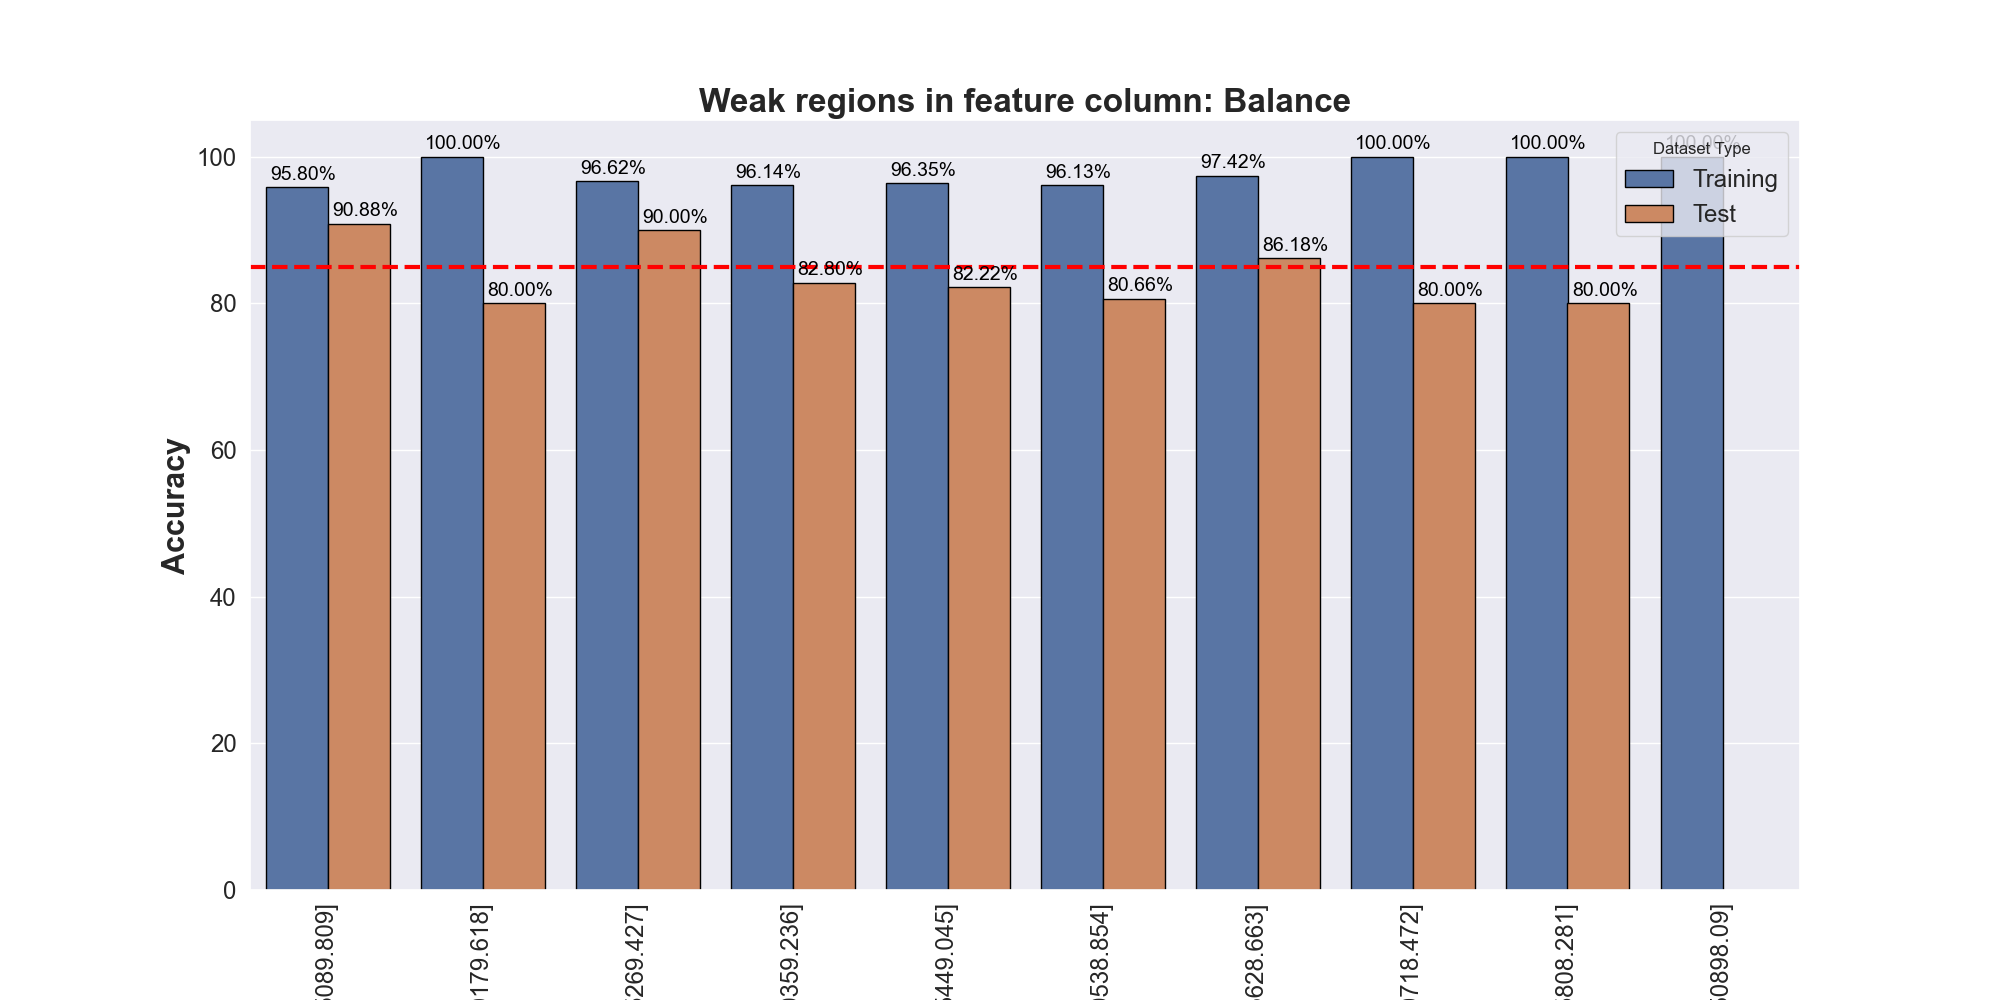
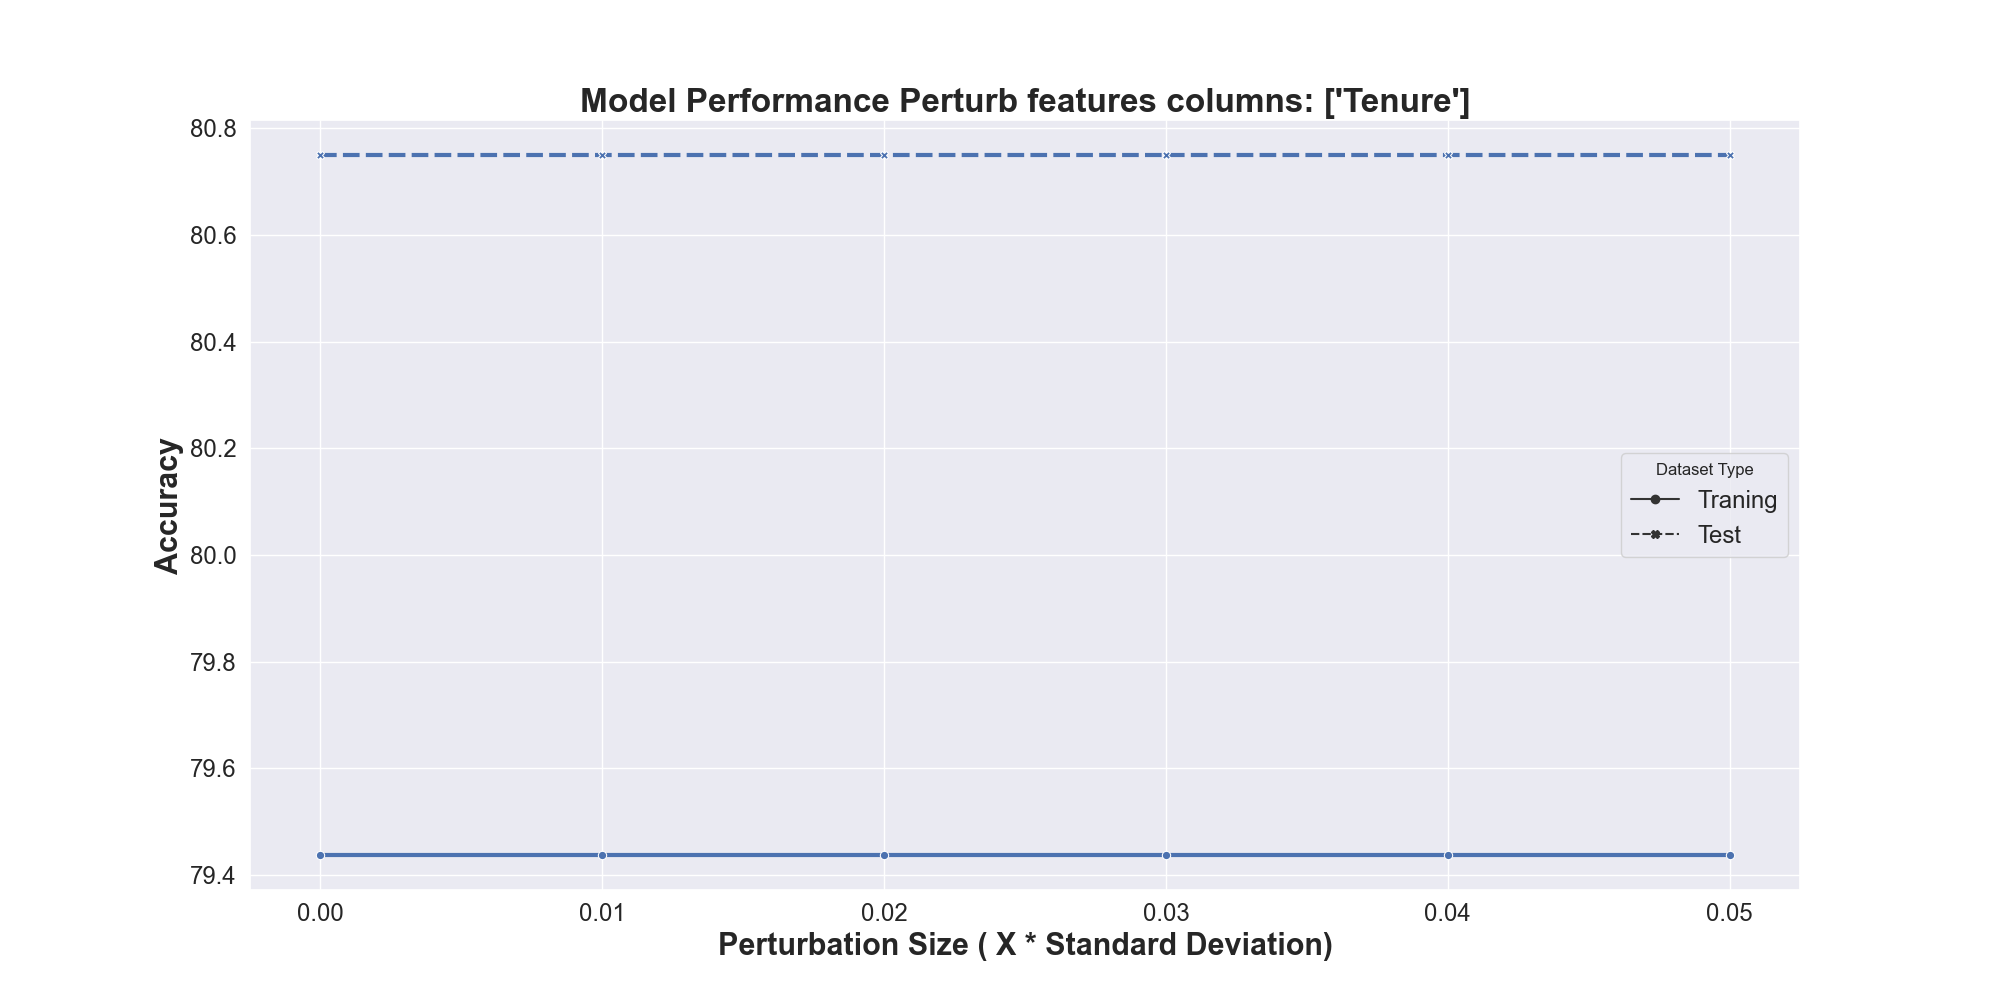

In [15]:
config={
    "overfit_regions": {
        "cut_off_percentage": 3,
        "feature_columns": ["Age", "Balance", "Tenure", "NumOfProducts"]
    },
    "weak_spots":{
        "features_columns": ["Age", "Balance"],
        "accuracy_gap_threshold": 85,
    },
    "robustness":{
        "features_columns": ["Tenure"],
        "scaling_factor_std_dev_list": [0.0, 0.01, 0.02, 0.03, 0.04, 0.05],
    }
}
vm.run_test_plan("sklearn_classifier_model_diagnosis", 
                 model=vm_model,
                 train_ds=vm_train_ds,
                 test_ds=vm_test_ds,
                 config=config)